# 🔬 Leukocytes images classification using Vision Transformers

***

## 📁 Set up the environment

#### Installing dependencies

In [1]:
!pip install -q wandb
!pip install -q datasets transformers
!pip install -q plotly-express

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.3.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.
pandas-profiling 3.3.0 requires matplotlib<3.6,>=3.2, but you have matplotlib 3.6.2 which is incompatible.
pandas-profiling 3.3.0 requires pandas!=1.4.0,<1.5,>1.1, but you have pandas 1.5.2 which is incompatible.
pandas-profiling 3.3.0 requires seaborn<0.12,>=0.10.1, but you have seaborn 0.12.1 which is incompatible.


#### Importing libraries and logging

In [2]:
from huggingface_hub import notebook_login


notebook_login()

In [3]:
import wandb


wandb.login()
# run = wandb.init(project="vit-classification-lcbsi", entity="polejowska")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin


True

In [4]:
from datasets import load_dataset, load_metric
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer

import torch
from torchvision.transforms import (
    Compose,
    Normalize,
    Resize,
    ToTensor,
)
import numpy as np
from tqdm import tqdm

from PIL import Image
import requests

import zipfile
from io import BytesIO
import gdown
import tensorflow as tf
from tensorflow import keras

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## 📚 Loading the dataset



In [ ]:
artifact = run.use_artifact('polejowska/lcbsi-wbc-monai-ai/raw_data:v0', type='dataset')

artifact_dir = artifact.download()

wandb: Downloading large artifact raw_data:v0, 34.94MB. 5002 files... 
wandb:   5002 of 5002 files downloaded.  
Done. 0:0:42.9


In [5]:
# https://huggingface.co/datasets/polejowska/lcbsi-wbc-ap
dataset = load_dataset("polejowska/lcbsi-wbc-ap")

Using custom data configuration polejowska--lcbsi-wbc-ap-35876f5f55923258


Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/750 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/3500 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/polej/.cache/huggingface/datasets/polejowska___parquet/polejowska--lcbsi-wbc-ap-35876f5f55923258/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset_path = "artifacts/raw_data-v0"

# dataset = load_dataset("imagefolder", data_files={"train": "/content/artifacts/raw_data-v0/train/**", "test": "artifacts/raw_data-v0/test/**", "valid": "artifacts/raw_data-v0/valid/**"})

## 🔍 Explore the dataset

In [6]:
print(f"Dataset structure: {dataset}\n")
print(f"Number of training examples: {len(dataset['train'])}\n")
print(f"Dataset sample (image, label): {dataset['train'][0]}\n")
print(f"Dataset features: {dataset['train'].features}\n")
print(f"Class labels: {dataset['train'].features['label'].names}\n")

Dataset structure: DatasetDict({
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 750
    })
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3500
    })
})

Number of training examples: 3500

Dataset sample (image, label): {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x2AAB79CB9D0>, 'label': 0}

Dataset features: {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'], id=None)}

Class labels: ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']



In [7]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [ ]:
wandb.config.update({"class_labels": dataset["train"].features["label"].names})
wandb.config.update({"num_train_examples": len(dataset["train"])})

#### Visualize data and display essential information

In [ ]:
def plot_class_distribution(dataset, id2label, dataset_name="dataset"):
    fig = px.histogram(
        x=[id2label[label] for label in dataset["label"]],
        title=f"Distribution of classes in the {dataset_name}",
    )
    fig.update_layout(xaxis_title="Class", yaxis_title="Number of examples")
    fig.show()
    return fig

enitre_dataset_fig = plot_class_distribution(dataset["train"], id2label)
wandb.log({"class distribution in the entire dataset": enitre_dataset_fig})

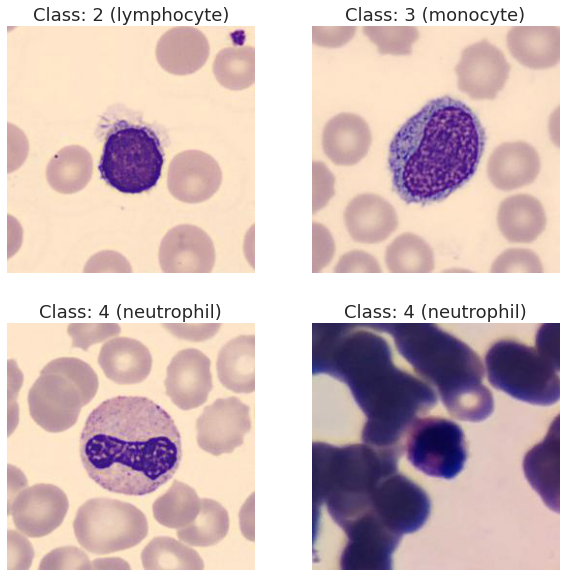

In [ ]:
def display_random_images(dataset, label2id, id2label):
    # display four random images from the dataset using plotly
    fig = plt.figure(figsize=(10, 10))
    for i in range(4):
        random_image = np.random.randint(0, len(dataset))
        image = dataset[random_image]["image"]
        label = dataset[random_image]["label"]
        class_name = id2label[label]

        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(image)
        ax.set_title(f"Class: {label} ({class_name})")
        ax.axis("off")
    plt.show()

    wandb.log({"random_images": fig})



display_random_images(dataset["train"], label2id, id2label)

***
## 🔨 Data processing

1. Resize images
2. Normalize RGB channels using mean and standard deviation

In [ ]:
# model_checkpoint = "microsoft/swin-tiny-patch4-window7-224"
# model_checkpoint = "facebook/convnext-tiny-224"
model_checkpoint = "google/vit-base-patch16-224-in21k"
# model_checkpoint = "nickmuchi/vit-base-xray-pneumonia"

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

In [ ]:
resize_value = (feature_extractor.size['height'], feature_extractor.size['width'])
# resize_value = (feature_extractor.size['shortest_edge'], feature_extractor.size['shortest_edge'])

In [ ]:
print(f"Resize value: {resize_value}")

Resize value: (224, 224)


In [ ]:
data_transforms = Compose(
        [
            Resize(resize_value),
            ToTensor(),
            Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ]
    )

In [ ]:
def add_pixel_values_feature(batch):
  batch["pixel_values"] = [
        data_transforms(image.convert("RGB")) for image in batch["image"]
  ]
  return batch

In [ ]:
train_dataset = dataset["train"].map(add_pixel_values_feature, batched=True)
validation_dataset = dataset["valid"].map(add_pixel_values_feature, batched=True)
test_dataset = dataset["test"].map(add_pixel_values_feature, batched=True)

print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(validation_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Length of training dataset: 3500
Length of validation dataset: 750
Length of test dataset: 750


In [ ]:
train_dataset_fig = plot_class_distribution(train_dataset, id2label, dataset_name="training dataset")
wandb.log({"class distribution in the training dataset": train_dataset_fig})

validation_dataset_fig = plot_class_distribution(validation_dataset, id2label, dataset_name="validation dataset")
wandb.log({"class distribution in the validation dataset": validation_dataset_fig})

test_dataset_fig = plot_class_distribution(test_dataset, id2label, dataset_name="test dataset")
wandb.log({"class distribution in the test dataset": test_dataset_fig})

In [ ]:
wandb.config.update({"num_train_examples": len(train_dataset)})
wandb.config.update({"num_validation_examples": len(validation_dataset)})
wandb.config.update({"num_test_examples": len(test_dataset)})

In [ ]:
train_dataset.set_transform(add_pixel_values_feature)
validation_dataset.set_transform(add_pixel_values_feature)
test_dataset.set_transform(add_pixel_values_feature)

#### W&B - log dataset tables

In [ ]:
def create_table(dataset):
    table = wandb.Table(columns=["image", "label", "class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label])

    return table

In [ ]:
train_table = create_table(train_dataset)
validation_table = create_table(validation_dataset)
test_table = create_table(test_dataset)

wandb.log({"train_dataset": train_table})
wandb.log({"validation_dataset": validation_table})
wandb.log({"test_dataset": test_table})

100%|██████████| 750/750 [01:42<00:00,  7.34it/s]


***
## 🚋 Model training

In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
wandb.watch(model, log="all", log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
MODEL_NAME = model_checkpoint.split("/")[-1]
NUM_TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
STRATEGY = "epoch"
wandb.run.name = f"{MODEL_NAME} (epochs: {NUM_TRAIN_EPOCHS}) (lr: {LEARNING_RATE})"


args = TrainingArguments(
    f"{MODEL_NAME}-lcbsi",
    remove_unused_columns=False,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="wandb",
    push_to_hub=True,
)

In [ ]:
def collate_fn(batches):
    pixel_values = torch.stack([batch["pixel_values"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
accuracy_metric = load_metric("accuracy")

<ipython-input-30-b26f5846bd21>:1: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate



In [ ]:
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=feature_extractor,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/polejowska/vit-base-patch16-224-in21k-lcbsi into local empty directory.


Download file pytorch_model.bin:   0%|          | 3.43k/327M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.37k/3.37k [00:00<?, ?B/s]

Clean file training_args.bin:  30%|##9       | 1.00k/3.37k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/327M [00:00<?, ?B/s]

In [ ]:
 trainer_results = trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 3500
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 270
  Number of trainable parameters = 85802501
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,0.519200,0.130936,0.972000
1,0.225300,0.205637,0.932000
2,0.104800,0.176627,0.950667
3,0.095400,0.076081,0.977333
4,0.060500,0.147624,0.958667
5,0.033700,0.087598,0.969333
6,0.028200,0.070757,0.980000
7,0.007600,0.061208,0.985333
8,0.004900,0.067404,0.982667
9,0.006200,0.065883,0.981333


***** Running Evaluation *****
  Num examples = 750
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-in21k-lcbsi/checkpoint-27
Configuration saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-27/config.json
Model weights saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-27/pytorch_model.bin
Image processor saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-27/preprocessor_config.json
Image processor saved in vit-base-patch16-224-in21k-lcbsi/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 32
Saving model checkpoint to vit-base-patch16-224-in21k-lcbsi/checkpoint-54
Configuration saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-54/config.json
Model weights saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-54/pytorch_model.bin
Image processor saved in vit-base-patch16-224-in21k-lcbsi/checkpoint-54/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 750
  Batch size = 32
Saving model checkpoint t

In [ ]:
trainer.save_model()

In [ ]:
trainer.log_metrics("train", trainer_results.metrics)
trainer.save_metrics("train", trainer_results.metrics)

***** train metrics *****
  epoch                    =         9.98
  total_flos               = 2522843725GF
  train_loss               =       0.1409
  train_runtime            =   1:02:46.55
  train_samples_per_second =        9.292
  train_steps_per_second   =        0.072


In [ ]:
trainer.save_state()

In [ ]:
# save model to W&B
model_artifact = wandb.Artifact(
    f"{MODEL_NAME}-lcbsi-wbc",
    type="model",
    description=f"model trained on {MODEL_NAME} for {NUM_TRAIN_EPOCHS} epochs",
)

wandb.log_artifact(model_artifact)

## 📈 Model evaluation

In [ ]:
metrics = trainer.evaluate()

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 750
  Batch size = 32


***** eval metrics *****
  epoch                   =       9.98
  eval_accuracy           =     0.9853
  eval_loss               =     0.0612
  eval_runtime            = 0:00:53.27
  eval_samples_per_second =     14.078
  eval_steps_per_second   =       0.45


In [ ]:
trainer.push_to_hub()

In [ ]:
def create_table_with_predictions(dataset, predictions):
    table = wandb.Table(columns=["image", "label", "class name", "prediction", "prediction class name"])

    for i in tqdm(range(len(dataset))):
        image, label = dataset[i]["image"], dataset[i]["label"]
        table.add_data(wandb.Image(image), label, id2label[label], predictions[i], id2label[predictions[i]])

    return table

In [ ]:
test_predictions = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
test_table_with_predictions = create_table_with_predictions(test_dataset, test_predictions)

***** Running Prediction *****
  Num examples = 750
  Batch size = 32


100%|██████████| 750/750 [01:47<00:00,  7.01it/s]


In [ ]:
wandb.log({"test_table_with_predictions": test_table_with_predictions})


test_table_with_predictions_artifact = wandb.Artifact(
    name="test_table_with_predictions",
    type="test_table_with_predictions",
    description="A table with predictions on the test dataset",
    metadata={
        "num_test_examples": len(test_dataset),
    },
)

test_table_with_predictions_artifact.add(test_table_with_predictions, "test_table_with_predictions")
wandb.log_artifact(test_table_with_predictions_artifact)

In [ ]:
confusion_matrix = wandb.plot.confusion_matrix(
    probs=None,
    y_true=test_dataset[:]["label"],
    preds=test_predictions,
    class_names=list(id2label.values()),
)

wandb.log({"confusion_matrix": confusion_matrix})

In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, class_names):
    fig = go.Figure(data=go.Heatmap(z=cm, x=class_names, y=class_names))
    fig.update_layout(
        title="Confusion Matrix",
        xaxis_title="Predicted label",
        yaxis_title="True label",
        annotations=[go.layout.Annotation(text=str(round(z, 2)), x=x, y=y,
                                            font_size=14, showarrow=False)
                        for x, y, z in zip(np.tile(class_names, len(class_names)), np.repeat(class_names, len(class_names)), cm.flatten())],
                        
    )
    fig.show()
    return fig


cm = confusion_matrix(test_dataset[:]["label"], test_predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_plot = plot_confusion_matrix(cm, list(id2label.values()))

wandb.log({"confusion_matrix (plotly)": cm_plot})


## Inference using transformers pipeline

In [ ]:
def load_image_from_url(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return image

img_url = 'https://huggingface.co/spaces/polejowska/LCBSI/resolve/main/95-8-24-1_190_1.jpg'
image = load_image_from_url(img_url)

In [ ]:
from transformers import pipeline


repo_name = "polejowska/swin-tiny-patch4-window7-224-lcbsi-wbc"
pipe = pipeline("image-classification", repo_name)

Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/388 [00:00<?, ?B/s]

In [ ]:
pipe(image)

[{'score': 0.9994284510612488, 'label': 'monocyte'},
 {'score': 0.00023444283579010516, 'label': 'eosinophil'},
 {'score': 0.00017420583753846586, 'label': 'basophil'},
 {'score': 0.00015998473099898547, 'label': 'lymphocyte'},
 {'score': 2.8791891963919625e-06, 'label': 'neutrophil'}]

In [ ]:
wandb.finish()

W&B report: https://wandb.ai/polejowska/vit-classification-lcbsi/reports/Leukocytes-classification-from-blood-smear-images--VmlldzozMTU1NjI0